# Plot method demonstration

This notebook makes demos of various plot methods to be used 
in the website. The underlying netCDF-files can (almost) all be found
at https://github.com/Chilipp/PhD-thesis/tree/master/psyplot-figures

In [1]:
import psyplot.project as psy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cf
import xarray as xr
import numpy as np
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
import seaborn as sns
import dask
from distributed import Client

%matplotlib inline

In [2]:
sns.set_style('dark')
psy.rcParams['plotter.maps.xgrid'] = False
psy.rcParams['plotter.maps.ygrid'] = False

In [3]:
x = np.linspace(-2 * np.pi, 2 * np.pi, 10)
y = np.linspace(-np.pi, np.pi, 10)
x2d, y2d = np.meshgrid(x, y)
triangles = mtri.Triangulation(x2d.ravel(), y2d.ravel())
z = (np.cos(triangles.x) + np.sin(triangles.y)) ** 2

# refine at high values
refiner = mtri.UniformTriRefiner(triangles)
triangles2, z2 = refiner.refine_field(z, subdiv=1)

triangles = mtri.Triangulation(
    np.r_[triangles.x[z < 1], triangles2.x[z2 >= 1]],
    np.r_[triangles.y[z < 1], triangles2.y[z2 >= 1]],
)
z = np.r_[z[z < 1], z2[z2 >= 1]]

ztri = z[triangles.get_masked_triangles()].mean(axis=1)

ds_tri2 = xr.Dataset(
    {"z": xr.Variable(("ncells",), ztri, attrs={"coordinates": "y x"})},
    {
        "x": xr.Variable(
            ("ncells",),
            triangles.x[triangles.triangles].mean(axis=1),
            attrs={"bounds": "xb"},
        ),
        "y": xr.Variable(
            ("ncells",),
            triangles.y[triangles.triangles].mean(axis=1),
            attrs={"bounds": "yb"},
        ),
        "xb": xr.Variable(("ncells", "bnds"), triangles.x[triangles.triangles]),
        "yb": xr.Variable(("ncells", "bnds"), triangles.y[triangles.triangles]),
    },
)

In [4]:
x2 = np.arange(0, 2 * np.pi, 0.5)
y2 = np.arange(0, 2 * np.pi, 0.5)
x22d, y22d = np.meshgrid(x2, y2)
z = np.cos(x22d) + np.sin(y22d)
ds2 = xr.Dataset(
    {
        "u": xr.Variable(("x", "y"), np.cos(x22d)),
        "v": xr.Variable(("x", "y"), np.sin(y22d)),
        "z": xr.Variable(("x", "y"), z),
    },
    {"x": xr.Variable(("x",), x2), "y": xr.Variable(("y",), y2)},
)

In [5]:
ds = xr.open_dataset(
    "/media/SommerP/Backup/Archive/Mac/data-volume/TRACE21/data/TRACE21/air.mon.mean-years.nc",
    decode_cf=False,
    chunks={"time": 500 * 12},
).sel(time=slice(-12000, 100))
ds["time"] = -ds.time

with Client() as client:
    with dask.config.set(scheduler=client):
        germany = (
            ds.sel(Lon=slice(0, 69), Lat=slice(34, 81))
            .groupby(ds.time.astype(int) - ds.time.astype(int) % 100 + 50)
            .mean("time")
            .load()
            - 273.15
        )
        ukraine = (
            ds.sel(Lon=slice(22.0, 40.0), Lat=slice(44.0, 52.0))
            .groupby(ds.time.astype(int) - ds.time.astype(int) % 100 + 50)
            .mean("time")
            .load()
            - 273.15
        )
        poland = (
            ds.sel(Lon=slice(14.0, 24.0), Lat=slice(49.0, 54.0))
            .groupby(ds.time.astype(int) - ds.time.astype(int) % 100 + 50)
            .mean("time")
            .load()
            - 273.15
        )



In [6]:
x = np.linspace(0, 100)
y = x * 4 + 30 + 50 * np.random.normal(size=x.size)
ds_reg = xr.Dataset(
    {"x": xr.Variable(("experiment",), x), "y": xr.Variable(("experiment",), y)}
)

In [7]:
all_x = []
all_y = []
for i in range(3):
    deviation = np.abs(np.random.normal())
    all_x.append(np.linspace(-np.pi - deviation, np.pi + deviation))
    all_x[-1] += 3 * np.random.random_sample(size=all_x[-1].size)
    all_y.append(
        np.sin(all_x[-1]) + np.random.normal(scale=0.5, size=all_x[-1].size)
    )
x = np.concatenate(all_x)
y = np.concatenate(all_y)
ds_reg2 = xr.Dataset(
    {"x": xr.Variable(("experiment",), x), "y": xr.Variable(("experiment",), y)}
)



/home/psommer/Documents/code/development/psy-reg/psy_reg/utils.py:88: RuntimeWarning: Need finite parameter boundaries for automatic initial parameter estimation!
  RuntimeWarning)


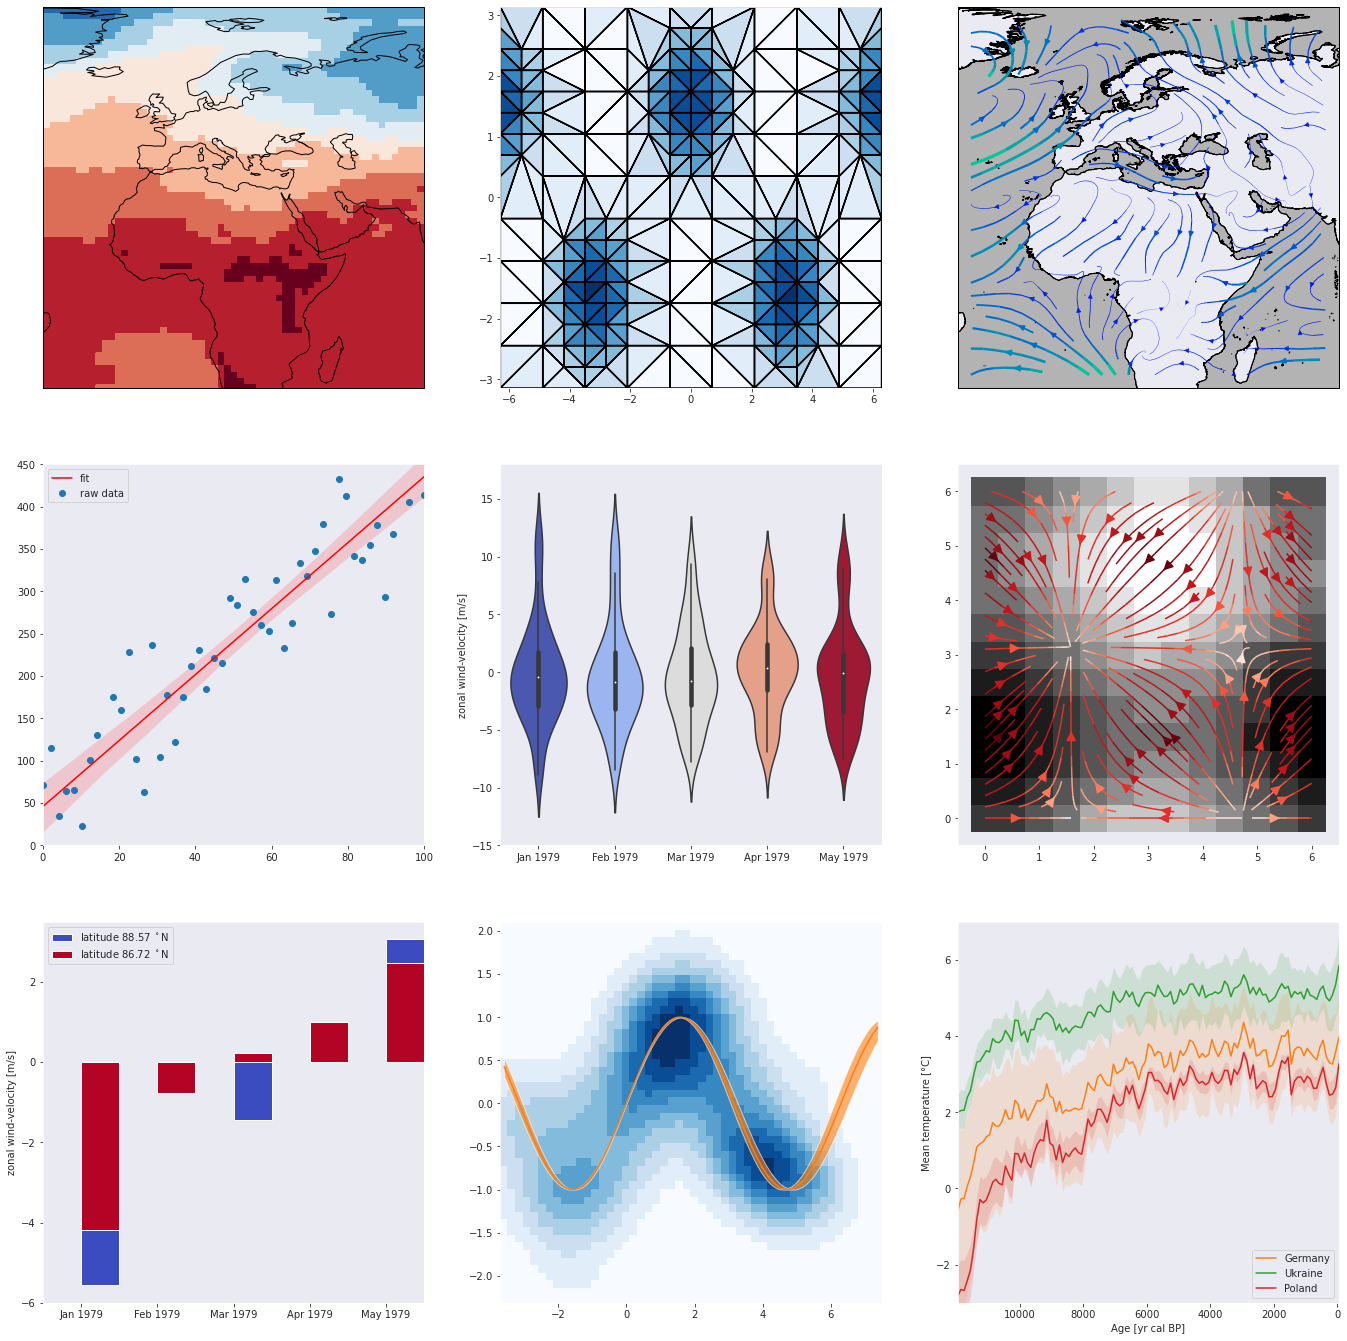

In [8]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(3, 3, 7)
bars = psy.plot.barplot(
    "demo.nc",  # netCDF file storing the data
    ax=ax,
    name="u",  # one plot for each variable
    y=[0, 1],  # two bars in total
    z=0,
    x=0,  # choose latitude and longitude as dimensions
    ylabel="{desc}",  # use the longname and units on the y-axis
    color="coolwarm",
    xticklabels="%b %Y",
    legendlabels="latitude %(y)1.2f $^\circ$N",
    legend="upper left",
)

ax = fig.add_subplot(3, 3, 5)
violins = psy.plot.violinplot(
    "demo.nc",  # netCDF file storing the data
    ax=ax,
    name="u",  # one plot for each variable
    t=range(5),  # one violin plot for each time step
    z=0,
    x=0,  # choose latitude and longitude as dimensions
    ylabel="{desc}",  # use the longname and units on the y-axis
    color="coolwarm",
    legend=False,
    xticklabels="%b %Y",  # choose xaxis labels to use month and year info,
    ylim=[-15, 18],
)

ax = fig.add_subplot(3, 3, 2)
p = ds_tri2.psy.plot.plot2d(
    name="z",
    cmap="Blues",
    datagrid="k-",
    xlim="minmax",
    ylim="minmax",
    cbar="",
    ax=ax,
)

ax = fig.add_subplot(3, 3, 6)
p = ds2.psy.plot.combined(
    name=[["z", ["u", "v"]]],
    cmap="binary",
    vcmap="Reds",
    color="absolute",
    cbar="",
    vcbar="",
    vplot="stream",
    arrowsize=2,
    ax=ax,
)

ax = fig.add_subplot(3, 3, 9)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"][1:]
l = psy.InteractiveList(
    [
        germany.air.rename("Germany"),
        ukraine.air.rename("Ukraine"),
        poland.air.rename("Poland"),
    ]
)
l.psy.plot.fldmean(
    legendlabels="%(name)s",
    mean="median",
    err_calc=[45, 55],
    xlim="minmax",
    ylim=(-3, 7),
    legend=dict(loc="lower right"),
    xlabel="Age [yr cal BP]",
    ylabel="Mean temperature [°C]",
    color=colors,
    ax=ax,
)
l.plotter.ax.invert_xaxis()

ax = fig.add_subplot(3, 3, 1, projection=ccrs.PlateCarree())
maps = psy.plot.mapplot(
    "psy-maps-demo.nc",
    name="t2m",
    clabel="{desc}",
    cmap="RdBu_r",
    cbar="",
    ax=ax,
    map_extent=(-37, 74, -27, 84),
)

ax = fig.add_subplot(3, 3, 3, projection=ccrs.PlateCarree())
vectors = psy.plot.mapvector(
    "psy-maps-demo.nc",
    name=[["u", "v"]],
    arrowsize=None,
    color="absolute",
    linewidth=["absolute", 0.3],
    lonlatbox=(-37, 74, -27, 84),
    ax=ax,
    map_extent=(-37, 74, -27, 84),
    cmap="winter",
    cbar="",
    stock_img=False,
    plot="stream",
    lsm={"ocean": "0.7", "coast": "k", "res": "10m"},
)

ax = fig.add_subplot(3, 3, 4)
raw = psy.plot.lineplot(
    ds_reg,
    name="y",
    coord="x",
    linewidth=0,
    marker="o",
    legendlabels="raw data",
    legend="upper left",
    ax=ax,
)
fit = psy.plot.linreg(
    ds_reg,
    ax=raw.plotters[0].ax,
    name="y",
    coord="x",
    legendlabels="fit",
    color="red",
)
fit.share(raw[0], keys="legend")

ax = fig.add_subplot(3, 3, 8)
p = psy.plot.densityreg(
    ds_reg2,
    name="y",
    coord="x",
    cmap="Blues",
    bins=50,
    density="kde",
    clabel="Kernel density",
    xlim="minmax",
    ylim="minmax",
    color=plt.rcParams["axes.prop_cycle"].by_key()["color"][1],
    fit=lambda x, a: np.sin(a * x),
    cbar="",
    erroralpha=0.6,
    legend=False,
    ax=ax,
)

for ax in fig.axes:
    ax.tick_params(top=False, right=False)
fig.subplots_adjust(bottom=0.05, left=0.05, top=0.95, right=0.95)
fig.savefig("../assets/images/example-plots.png", dpi=100)

In [9]:
psy.close('all')